In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.9 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F
from tqdm import tqdm
import nltk
import textstat
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForCausalLM
nltk.download('punkt')
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# ==========================
# Load your data
# ==========================

# train_df = pd.read_csv("Training_Essay_Data.csv")

train_df = pd.read_json("train.jsonl", lines=True)
val_df = pd.read_json("val.jsonl", lines=True)
# # df = pd.concat([train_df, val_df], ignore_index=True)
print(val_df.head())

                                     id  \
0  7caf42b9-fd48-5e97-a0d0-0ae28a1f9603   
1  28b61fc4-e82b-5cf8-bc34-1ecdb7182993   
2  22398c76-da72-5724-973e-0981b8e9cbee   
3  3cd1e50d-e1f0-5f8f-bfb8-0b8a6048bcaa   
4  6e5745a6-0335-50cc-bdf0-fa0e1fee7518   

                                                text                   model  \
0  In William Faulkner's "The Sound and the Fury,...                  gpt-4o   
1  Manipulation, a profound and pervasive theme i...         gpt-4.5-preview   
2  Edna's journey is a testament to her rebellion...  llama-3.3-70b-instruct   
3  There are three main aspects of the gun contro...                   human   
4  During the Portuguese colonial period in Angol...                  gpt-4o   

   label   genre  
0      1  essays  
1      1  essays  
2      1  essays  
3      0  essays  
4      1  essays  


In [5]:
train_df.head()

id  \
0  ea468d03-1973-5039-86b2-ff225bb92c4e   
1  0d05f269-6d67-521d-9b5d-cc18f482c6c1   
2  c2ec79f3-da80-58f8-bef0-3e0ea7ab072f   
3  4ad37c58-0bb7-536b-997d-cfccabd0d094   
4  07747b0c-5051-5e0d-8096-b4d4ed8bd98e   

                                                text  \
0  Duke Ellington, a titan of jazz, revolutionize...   
1  I reflected on the shifting dynamics of media ...   
2  In F. Scott Fitzgerald's "The Great Gatsby," t...   
3  I still chuckle when I think about that time I...   
4  Yoga, originating in ancient India, encompasse...   

                          model  label   genre  
0          falcon3-10b-instruct      1  essays  
1                       o3-mini      1  essays  
2                        gpt-4o      1  essays  
3  deepseek-r1-distill-qwen-32b      1  essays  
4              gemini-2.0-flash      1  essays

In [4]:
# Load observer and performer models
observer_model_name = "gpt2"
performer_model_name = "gpt2"

observer_model = AutoModelForCausalLM.from_pretrained(observer_model_name)
observer_tokenizer = AutoTokenizer.from_pretrained(observer_model_name)

performer_model = AutoModelForCausalLM.from_pretrained(performer_model_name)
performer_tokenizer = AutoTokenizer.from_pretrained(performer_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
observer_model.to(device)
performer_model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [7]:
def calculate_perplexity(model, tokenizer, text, device="cuda", median=False):
    """
    Computes the perplexity of a language model's output for a given text.

    Parameters:
    - model (nn.Module): Pre-trained language model.
    - tokenizer: Tokenizer compatible with the model.
    - text (str): Input text.
    - device (str): Device to run the model on ('cuda' or 'cpu').
    - median (bool): Whether to compute median perplexity instead of mean.

    Returns:
    - float or np.ndarray: Perplexity score.
    """

    # Preprocessing
    text = text.strip()
    if not text:
        return float('inf')

    # Tokenize and move to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Shift logits and labels for next-token prediction
    shifted_logits = logits[:, :-1, :]
    labels = inputs['input_ids'][:, 1:]
    attention_mask = inputs['attention_mask'][:, 1:]

    # Cross-entropy loss calculation
    log_probs = F.log_softmax(shifted_logits, dim=-1)
    loss = F.nll_loss(
        log_probs.transpose(1, 2),  # Switch to (batch_size, vocab_size, seq_len)
        labels,
        reduction='none'
    )

    # Mask padding tokens
    loss = loss * attention_mask

    # Mean or median perplexity
    if median:
        loss[attention_mask == 0] = float('nan')  # Mask invalid tokens with NaN
        ppl = np.nanmedian(loss.cpu().numpy(), axis=1)
    else:
        loss_sum = loss.sum(dim=1)
        valid_tokens = attention_mask.sum(dim=1)
        ppl = torch.exp(loss_sum / valid_tokens).cpu().numpy()

    # Return scalar if single sample, array if batch
    return ppl[0] if ppl.shape[0] == 1 else ppl


def calculate_cross_perplexity_with_logits(
    observer_model,
    performer_model,
    tokenizer,
    text,
    device="cuda",
    max_length=512,
    median=False
):

    # Preprocessing
    text = text.strip()
    if not text:
        return float('inf')

    # Tokenize input and send to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)

    # Get logits from both models
    with torch.no_grad():
        p_outputs = performer_model(**inputs)
        q_outputs = observer_model(**inputs)

    # Extract logits
    p_logits = p_outputs.logits
    q_logits = q_outputs.logits

    # Compute cross-entropy between p_logits and q_logits
    cross_entropy = F.kl_div(
        F.log_softmax(q_logits, dim=-1),
        F.softmax(p_logits, dim=-1),
        reduction='batchmean'
    )
    # Convert to perplexity
    cross_perplexity = torch.exp(cross_entropy).item()
    return cross_perplexity

def calculate_perplexity_ratio(observer_model, performer_model, tokenizer, text):
    text = text.strip()
    perplexity = calculate_perplexity(observer_model, tokenizer, text)
    cross_perplexity = calculate_cross_perplexity_with_logits(observer_model, performer_model, tokenizer, text)
    ratio =  perplexity / cross_perplexity
    return ratio

# def process_dataframe(df, observer_model, performer_model, tokenizer):
#     results = []
#     for _, row in df.iterrows():
#         result = {"ID":row["id"]}
#         result["Binocular score"] = calculate_perplexity_ratio(observer_model, performer_model, tokenizer, row["text"])
#         results.append(result)
#     return pd.DataFrame(results)

In [8]:
# ==========================
# Your Binocular Score
# ==========================
# def binocular_score(text):
#     # Replace this with your actual binocular score logic
#     return np.random.rand()

# binocular_feature = np.array([[calculate_perplexity_ratio(observer_model, performer_model, tokenizer,t)] for t in df['text']])

# ## Reading Binocular score from file
# df_binocular = pd.read_csv("Binocular_score.csv")
# binocular_feature = df_binocular['Binocular score'].to_numpy()

# ==========================
# Feature: BERT Embeddings (PyTorch)
# ==========================
class BERTEmbedder:
    def __init__(self, model_name='bert-base-uncased', device=None):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()

    def encode(self, texts, batch_size=8):
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="BERT encoding"):
            batch = texts[i:i+batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
            encoded_input = {k: v.to(self.device) for k, v in encoded_input.items()}
            with torch.no_grad():
                output = self.model(**encoded_input)
            # Average token embeddings
            embeddings = output.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings.cpu())
        return torch.cat(all_embeddings).numpy()

bert_embedder = BERTEmbedder()

def feature_extractors(df,bert_embedder,observer_model,performer_model,tokenizer):

    binocular_feature = np.array([[calculate_perplexity_ratio(observer_model, performer_model, tokenizer,t)] for t in df['text']])

    bert_features = bert_embedder.encode(df['text'].tolist())

    # ==========================
    # Feature: Text Length
    # ==========================
    length_feature = np.array([[len(word_tokenize(t))] for t in df['text']])

    # ==========================
    # Feature: Readability
    # ==========================
    readability_feature = np.array([[textstat.flesch_reading_ease(t)] for t in df['text']])

    # ==========================
    # Feature: TF-IDF
    # ==========================
    tfidf_vectorizer = TfidfVectorizer(max_features=200)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

    return tfidf_matrix, bert_features, length_feature, readability_feature,binocular_feature




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
# ==========================
# Combine All Features
# ==========================
# training data feature extraction
tfidf_matrix, bert_features, length_feature, readability_feature,binocular_feature = feature_extractors(train_df,bert_embedder,observer_model,performer_model,observer_tokenizer)



BERT encoding: 100%|██████████| 2964/2964 [14:48<00:00,  3.34it/s]


In [10]:
# binocular_feature = binocular_feature.reshape(-1, 1)


X_combined = np.hstack([
    binocular_feature,
    tfidf_matrix.toarray(),
    bert_features,
    length_feature,
    readability_feature
])

y_train = train_df['label'].values

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:01:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


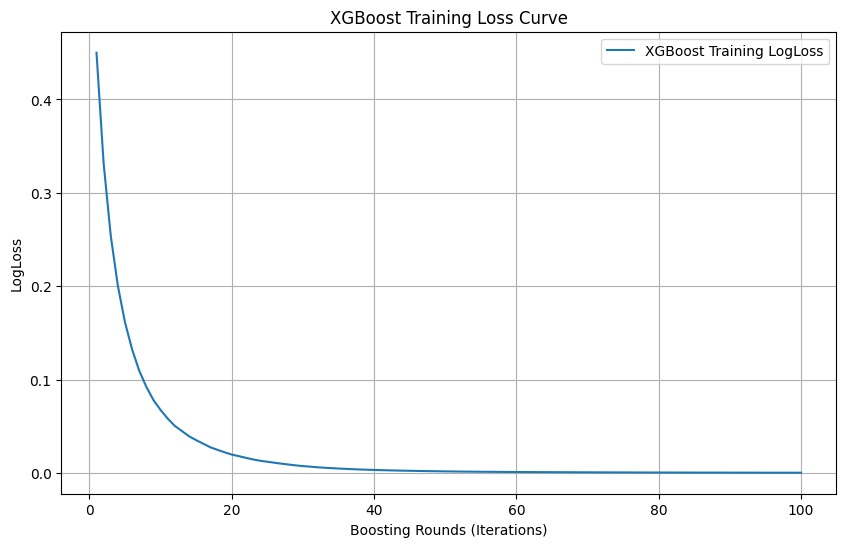

XGBoost training complete.

Training Random Forest Meta-Model...
Random Forest training complete.


In [11]:
# ==========================
# Base Model: XGBoost
# ==========================
print("Training XGBoost...")
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss', # Use logloss for evaluation
    random_state=42       # For reproducibility
)

# Define the evaluation set (using the training data itself)
eval_set = [(X_combined, y_train)]

# Fit the model, providing the evaluation set
xgb.fit(
    X_combined,
    y_train,
    eval_set=eval_set,
    verbose=False # Set to True or a number to see progress during training
)

# Retrieve the evaluation results
results = xgb.evals_result()
train_logloss = results['validation_0']['logloss'] # 'validation_0' corresponds to the first item in eval_set

# Plot the training loss curve for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_logloss) + 1), train_logloss, label='XGBoost Training LogLoss')
plt.title('XGBoost Training Loss Curve')
plt.xlabel('Boosting Rounds (Iterations)')
plt.ylabel('LogLoss')
plt.legend()
plt.grid(True)
plt.show()

print("XGBoost training complete.")

# Get predictions from XGBoost (as input for the meta-model)
# Use predict_proba as you were doing, good for stacking
xgb_train_preds = xgb.predict_proba(X_combined)

# ==========================
# Meta Model: Random Forest
# ==========================
print("\nTraining Random Forest Meta-Model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest using XGBoost predictions as features
rf.fit(xgb_train_preds, y_train)
print("Random Forest training complete.")

# Final predictions from the stacked model
final_preds = rf.predict(xgb_train_preds)

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, final_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [14]:
# df_binocular = pd.read_csv("Binocular_score_val.csv")
# binocular_feature = df_binocular['Binocular score'].to_numpy()

tfidf_matrix, bert_features, length_feature, readability_feature,binocular_feature = feature_extractors(val_df,bert_embedder,observer_model,performer_model,observer_tokenizer)
# binocular_feature = binocular_feature.reshape(-1, 1)

X_combined = np.hstack([
    binocular_feature,
    tfidf_matrix.toarray(),
    bert_features,
    length_feature,
    readability_feature
])

y_val = val_df['label'].values

BERT encoding: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]


In [15]:
# ==========================
# Final Predictions & Evaluation
# ==========================
xgb_test_preds = xgb.predict_proba(X_combined)
final_preds = rf.predict(xgb_test_preds)
print(classification_report(y_val, final_preds, target_names=["Human", "AI"]))

accuracy = accuracy_score(y_val, final_preds)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       Human       0.98      0.96      0.97      1277
          AI       0.98      0.99      0.98      2312

    accuracy                           0.98      3589
   macro avg       0.98      0.98      0.98      3589
weighted avg       0.98      0.98      0.98      3589

Accuracy: 0.978824185009752


In [16]:
from sklearn.metrics import f1_score

# Assuming 'y_val' are the true labels and 'final_preds' are the predicted labels
f1 = f1_score(y_val, final_preds)
print(f"F1 Score: {f1}")

F1 Score: 0.9836136265631737


In [17]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_val' are the true labels and 'final_preds' are the predicted labels
cm = confusion_matrix(y_val, final_preds)

# Option 1: Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1232   45]
 [  31 2281]]


In [19]:
### Data from Kaggle to check model effectiveness

data_1 = pd.read_csv("Training_Essay_Data.csv")
data_1.head()

text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1

In [20]:
tfidf_matrix, bert_features, length_feature, readability_feature,binocular_feature = feature_extractors(data_1,bert_embedder,observer_model,performer_model,observer_tokenizer)

BERT encoding: 100%|██████████| 3644/3644 [15:14<00:00,  3.99it/s]


In [21]:
X_combined = np.hstack([
    binocular_feature,
    tfidf_matrix.toarray(),
    bert_features,
    length_feature,
    readability_feature
])

y_1 = data_1['generated'].values

In [22]:
# ==========================
# Final Predictions & Evaluation
# ==========================
xgb_test_preds = xgb.predict_proba(X_combined)
final_preds = rf.predict(xgb_test_preds)
print(classification_report(y_1, final_preds, target_names=["Human", "AI"]))

accuracy = accuracy_score(y_1, final_preds)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       Human       0.87      0.99      0.93     17508
          AI       0.99      0.78      0.87     11637

    accuracy                           0.91     29145
   macro avg       0.93      0.89      0.90     29145
weighted avg       0.92      0.91      0.91     29145

Accuracy: 0.9092468691027621
